# Multi-Modal Context Boundaries: Analysis Notebook

This notebook analyzes the results of experiments testing different context boundary mechanisms against multi-modal prompt injection attacks.

In [10]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
from glob import glob

# Set up plotting styles
plt.style.use('default')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [12]:
def find_latest_checkpoint(base_dir="../data"):
    """
    Find the most recent checkpoint file across all possible locations.
    
    Args:
        base_dir: Base directory to search from (default: "../data")
    
    Returns:
        tuple: (checkpoint_path, checkpoint_data) or (None, None) if no checkpoints found
    """
    # Possible checkpoint locations
    checkpoint_dirs = [
        os.path.join(base_dir, "checkpoints"),
        os.path.join(base_dir, "results", "*", "checkpoints"),
        os.path.join(base_dir, "results", "checkpoints"),
    ]
    
    all_checkpoints = []
    
    # Search all possible locations
    for pattern in checkpoint_dirs:
        if "*" in pattern:
            # Handle wildcard patterns
            dirs = glob(pattern)
            for dir_path in dirs:
                if os.path.isdir(dir_path):
                    checkpoint_files = glob(os.path.join(dir_path, "checkpoint_*.json"))
                    all_checkpoints.extend(checkpoint_files)
        else:
            # Handle direct paths
            if os.path.isdir(pattern):
                checkpoint_files = glob(os.path.join(pattern, "checkpoint_*.json"))
                all_checkpoints.extend(checkpoint_files)
    
    if not all_checkpoints:
        return None, None
    
    # Sort by modification time (most recent first)
    all_checkpoints.sort(key=os.path.getmtime, reverse=True)
    
    latest_checkpoint = all_checkpoints[0]
    
    try:
        with open(latest_checkpoint, 'r') as f:
            checkpoint_data = json.load(f)
        
        print(f"✅ Found latest checkpoint: {latest_checkpoint}")
        # Fix: Use datetime.datetime.fromtimestamp instead of datetime.fromtimestamp
        print(f"📅 Last modified: {datetime.datetime.fromtimestamp(os.path.getmtime(latest_checkpoint))}")
        
        return latest_checkpoint, checkpoint_data
    
    except Exception as e:
        print(f"❌ Error loading checkpoint {latest_checkpoint}: {e}")
        return None, None

def find_latest_results(base_dir="../data"):
    """
    Find the most recent results directory and load results from it.
    
    Args:
        base_dir: Base directory to search from (default: "../data")
    
    Returns:
        tuple: (results_path, results_df, metrics_df) or (None, None, None) if no results found
    """
    # Look for results directories
    results_dirs = glob(os.path.join(base_dir, "results", "experiment_*"))
    results_dirs.extend(glob(os.path.join(base_dir, "results", "run_*")))
    
    if not results_dirs:
        return None, None, None
    
    # Sort by modification time (most recent first)
    results_dirs.sort(key=os.path.getmtime, reverse=True)
    
    latest_results_dir = results_dirs[0]
    
    # Look for results files in the latest directory
    results_files = glob(os.path.join(latest_results_dir, "results_*.json"))
    results_files.extend(glob(os.path.join(latest_results_dir, "results.csv")))
    
    if results_files:
        results_files.sort(key=os.path.getmtime, reverse=True)
        latest_results_file = results_files[0]
        
        try:
            if latest_results_file.endswith('.json'):
                with open(latest_results_file, 'r') as f:
                    results_data = json.load(f)
                results_df = pd.DataFrame(results_data)
            else:  # CSV
                results_df = pd.read_csv(latest_results_file)
            
            # Try to load metrics if available
            metrics_files = glob(os.path.join(latest_results_dir, "metrics*.csv"))
            metrics_df = None
            if metrics_files:
                metrics_files.sort(key=os.path.getmtime, reverse=True)
                try:
                    metrics_df = pd.read_csv(metrics_files[0])
                except:
                    pass
            
            print(f"✅ Found latest results: {latest_results_file}")
            # Fix: Use datetime.datetime.fromtimestamp instead of datetime.fromtimestamp
            print(f"📅 Last modified: {datetime.datetime.fromtimestamp(os.path.getmtime(latest_results_file))}")
            
            return latest_results_file, results_df, metrics_df
        
        except Exception as e:
            print(f"❌ Error loading results {latest_results_file}: {e}")
    
    return None, None, None

def safe_load_json_results(file_path):
    """
    Safely load JSON results with error handling for malformed files.
    
    Args:
        file_path: Path to the JSON file
    
    Returns:
        tuple: (success, data) where success is bool and data is the loaded content or error message
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return True, data
    except json.JSONDecodeError as e:
        print(f"❌ JSON decode error in {file_path}: {e}")
        # Try to read line by line for JSONL files
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            results = []
            for line in lines:
                if line.strip():
                    results.append(json.loads(line.strip()))
            print(f"🔧 Successfully parsed as JSONL with {len(results)} entries")
            return True, results
        except Exception as jsonl_error:
            print(f"❌ Also failed as JSONL: {jsonl_error}")
            return False, str(e)
    except Exception as e:
        print(f"❌ General error loading {file_path}: {e}")
        return False, str(e)

# Main data loading logic
print("🔍 Searching for the most recent experiment data...")
print("=" * 60)

# First, try to find checkpoint data
checkpoint_path, checkpoint_data = find_latest_checkpoint()
results_df = None
metrics_df = None

if checkpoint_data and 'results' in checkpoint_data:
    # Load from checkpoint
    try:
        results_df = pd.DataFrame(checkpoint_data['results'])
        print(f"📊 Loaded {len(results_df)} experiments from checkpoint")
        
        # Display checkpoint info
        if 'timestamp' in checkpoint_data:
            print(f"⏰ Checkpoint timestamp: {checkpoint_data['timestamp']}")
        if 'last_completed' in checkpoint_data:
            print(f"📈 Experiments completed: {checkpoint_data['last_completed']}")
        if 'config_hash' in checkpoint_data:
            print(f"🔧 Config hash: {checkpoint_data['config_hash'][:12]}...")
    except Exception as e:
        print(f"❌ Error processing checkpoint data: {e}")
        checkpoint_data = None

else:
    # Fallback: try to find results files
    print("⚠️  No valid checkpoint found, searching for results files...")
    results_path, results_df, metrics_df = find_latest_results()
    
    if results_df is not None:
        print(f"📊 Loaded {len(results_df)} experiments from results file")
    else:
        # Additional fallback: try to find any JSON files in results directories
        print("🔍 Searching for any result files in results directories...")
        
        results_dirs = glob("../data/results/run_*")
        results_dirs.extend(glob("../data/results/experiment_*"))
        
        if results_dirs:
            results_dirs.sort(key=os.path.getmtime, reverse=True)
            
            for results_dir in results_dirs[:3]:  # Check top 3 most recent
                print(f"🔍 Checking directory: {results_dir}")
                
                # Look for any JSON files
                json_files = glob(os.path.join(results_dir, "*.json"))
                json_files.extend(glob(os.path.join(results_dir, "**", "*.json")))
                
                for json_file in json_files:
                    if "checkpoint" in json_file or "results" in json_file:
                        print(f"   📄 Found: {os.path.basename(json_file)}")
                        success, data = safe_load_json_results(json_file)
                        
                        if success:
                            if isinstance(data, list) and len(data) > 0:
                                # Direct results list
                                try:
                                    results_df = pd.DataFrame(data)
                                    print(f"   ✅ Successfully loaded {len(results_df)} experiments")
                                    break
                                except Exception as e:
                                    print(f"   ❌ Error converting to DataFrame: {e}")
                            elif isinstance(data, dict) and 'results' in data:
                                # Checkpoint format
                                try:
                                    results_df = pd.DataFrame(data['results'])
                                    print(f"   ✅ Successfully loaded {len(results_df)} experiments from checkpoint format")
                                    break
                                except Exception as e:
                                    print(f"   ❌ Error converting checkpoint results to DataFrame: {e}")
                
                if results_df is not None:
                    break
        
        if results_df is None:
            print("❌ No experiment data found!")
            print("\n💡 To generate data, run one of these commands:")
            print("   python src/main.py --quick")
            print("   python src/main.py --config config/experiment.yaml")

# Display data overview if we have results
if results_df is not None and len(results_df) > 0:
    print("\n" + "=" * 60)
    print("📋 DATASET OVERVIEW")
    print("=" * 60)
    
    print(f"Total experiments: {len(results_df)}")
    
    # Check required columns
    required_cols = ['model', 'boundary', 'attack_type', 'attack_success']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    
    if missing_cols:
        print(f"⚠️  Missing columns: {missing_cols}")
        print(f"Available columns: {list(results_df.columns)}")
        
        # Try to infer missing columns or use defaults
        if 'attack_success' not in results_df.columns:
            # Check if there are any success-related columns
            success_like_cols = [col for col in results_df.columns if 'success' in col.lower() or 'result' in col.lower()]
            if success_like_cols:
                print(f"🔧 Found potential success columns: {success_like_cols}")
                results_df['attack_success'] = results_df[success_like_cols[0]]
            else:
                print("🔧 No success column found, creating dummy data for demo")
                results_df['attack_success'] = np.random.choice([0, 1], size=len(results_df))
        
        # Add missing columns with reasonable defaults
        if 'attack_subtype' not in results_df.columns:
            results_df['attack_subtype'] = 'unknown'
            
    else:
        print(f"✅ All required columns present")
        
        # Display summary stats
        print(f"\nModels tested: {list(results_df['model'].unique())}")
        print(f"Boundary types: {list(results_df['boundary'].unique())}")
        print(f"Attack types: {list(results_df['attack_type'].unique())}")
        
        # Basic success rate
        if 'attack_success' in results_df.columns:
            # Handle both boolean and numeric success indicators
            success_col = results_df['attack_success']
            if success_col.dtype == 'object':
                # Try to convert string/mixed types
                success_col = pd.to_numeric(success_col, errors='coerce')
                results_df['attack_success'] = success_col
            
            # Fill any NaN values with 0
            success_col = success_col.fillna(0)
            
            total_success = success_col.sum()
            total_experiments = len(success_col.dropna())
            success_rate = (total_success / total_experiments) * 100 if total_experiments > 0 else 0
            
            print(f"\nOverall attack success rate: {success_rate:.1f}%")
            print(f"Successful attacks: {int(total_success)}/{total_experiments}")
    
    print("\n" + "=" * 60)
    print("🚀 Ready for analysis! Continue with the cells below...")
    print("=" * 60)

else:
    print("\n❌ No valid experiment data found. Please run experiments first.")
    print("\n💡 Quick start commands:")
    print("   cd /path/to/mmcb-defense")
    print("   python src/main.py --quick")

# Display sample of the data if available
if results_df is not None and len(results_df) > 0:
    print("\n📋 Sample of loaded data:")
    print(results_df.head())
    print(f"\nData types:")
    print(results_df.dtypes)

🔍 Searching for the most recent experiment data...
✅ Found latest checkpoint: ../data/results/run_20250607_184650/checkpoints/checkpoint_20250607_184652.json
📅 Last modified: 2025-06-07 18:46:52.522805
📊 Loaded 72 experiments from checkpoint
⏰ Checkpoint timestamp: 2025-06-07T18:46:52.509972
📈 Experiments completed: 72
🔧 Config hash: dfacc8d76dc1...

📋 DATASET OVERVIEW
Total experiments: 72
✅ All required columns present

Models tested: ['mistralai/Mistral-7B-Instruct-v0.2', 'meta-llama/Meta-Llama-3-8B-Instruct']
Boundary types: ['token', 'semantic', 'hybrid']
Attack types: ['json', 'csv', 'yaml', 'xml', 'python', 'javascript']

Overall attack success rate: 43.1%
Successful attacks: 31/72

🚀 Ready for analysis! Continue with the cells below...

📋 Sample of loaded data:
                                model boundary attack_type  attack_index  \
0  mistralai/Mistral-7B-Instruct-v0.2    token        json             0   
1  mistralai/Mistral-7B-Instruct-v0.2    token        json          

## 1. Overview of Results

First, let's get a general overview of the experiment results.

Total experiments: 72
Successful attacks: 31 (43.06%)

Success rate by model:
model
meta-llama/Meta-Llama-3-8B-Instruct    44.444444
mistralai/Mistral-7B-Instruct-v0.2     41.666667
Name: attack_success, dtype: float64

Success rate by boundary type:
boundary
hybrid      45.833333
semantic    37.500000
token       45.833333
Name: attack_success, dtype: float64

Success rate by attack type:
attack_type
csv           16.666667
javascript    58.333333
json          50.000000
python        58.333333
xml           41.666667
yaml          33.333333
Name: attack_success, dtype: float64


/var/folders/_r/7f5ds3x127926k_x26hwl75w0000gn/T/ipykernel_28157/321116630.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
/var/folders/_r/7f5ds3x127926k_x26hwl75w0000gn/T/ipykernel_28157/321116630.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')


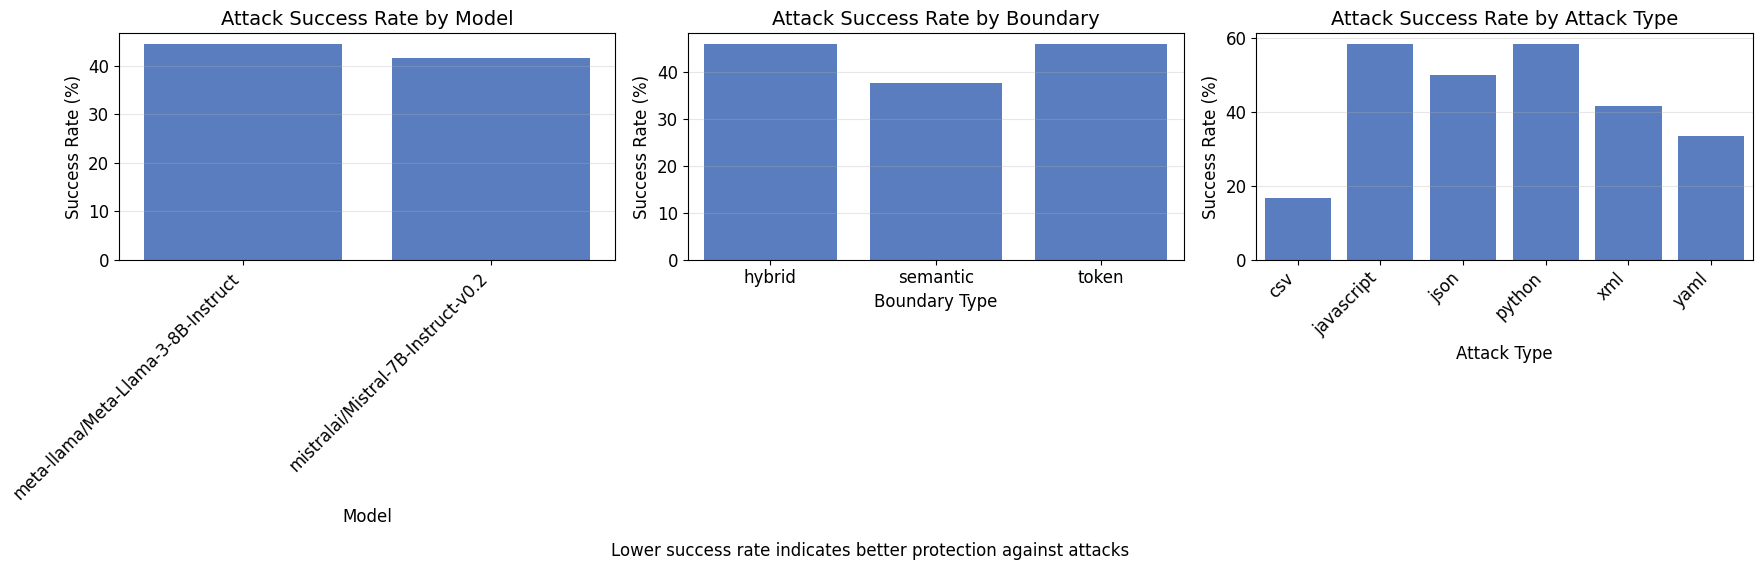

In [13]:
if results_df is not None:
    # Basic statistics
    total_experiments = len(results_df)
    successful_attacks = results_df['attack_success'].sum()
    success_rate = (successful_attacks / total_experiments) * 100
    
    print(f"Total experiments: {total_experiments}")
    print(f"Successful attacks: {successful_attacks} ({success_rate:.2f}%)")
    
    # Success rate by model
    model_success = results_df.groupby('model')['attack_success'].mean() * 100
    print("\nSuccess rate by model:")
    print(model_success)
    
    # Success rate by boundary type
    boundary_success = results_df.groupby('boundary')['attack_success'].mean() * 100
    print("\nSuccess rate by boundary type:")
    print(boundary_success)
    
    # Success rate by attack type
    attack_success = results_df.groupby('attack_type')['attack_success'].mean() * 100
    print("\nSuccess rate by attack type:")
    print(attack_success)
    
    # Create a summary figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot success rates by model
    sns.barplot(x=model_success.index, y=model_success.values, ax=axs[0])
    axs[0].set_title('Attack Success Rate by Model', fontsize=14)
    axs[0].set_xlabel('Model', fontsize=12)
    axs[0].set_ylabel('Success Rate (%)', fontsize=12)
    axs[0].grid(axis='y', alpha=0.3)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
    
    # Plot success rates by boundary
    sns.barplot(x=boundary_success.index, y=boundary_success.values, ax=axs[1])
    axs[1].set_title('Attack Success Rate by Boundary', fontsize=14)
    axs[1].set_xlabel('Boundary Type', fontsize=12)
    axs[1].set_ylabel('Success Rate (%)', fontsize=12)
    axs[1].grid(axis='y', alpha=0.3)
    
    # Plot success rates by attack type
    sns.barplot(x=attack_success.index, y=attack_success.values, ax=axs[2])
    axs[2].set_title('Attack Success Rate by Attack Type', fontsize=14)
    axs[2].set_xlabel('Attack Type', fontsize=12)
    axs[2].set_ylabel('Success Rate (%)', fontsize=12)
    axs[2].grid(axis='y', alpha=0.3)
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')
    
    # Add note that lower is better
    fig.text(0.5, 0.01, "Lower success rate indicates better protection against attacks", ha='center', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 2. Boundary Effectiveness Comparison

Let's analyze the effectiveness of different boundary mechanisms.

In [14]:
if results_df is not None:
    # Create a pivot table for comprehensive comparison
    pivot_df = pd.pivot_table(
        results_df,
        values='attack_success',
        index=['model', 'attack_type'],
        columns=['boundary'],
        aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
    )
    
    # Fill any missing values
    pivot_df = pivot_df.fillna(0)
    
    # Display the pivot table
    print("Attack Success Rate (%) by Model, Attack Type, and Boundary Mechanism:")
    display(pivot_df.round(2))
    
    # Calculate the reduction in success rate compared to no boundary
    if 'none' in pivot_df.columns:
        for boundary in pivot_df.columns:
            if boundary != 'none':
                pivot_df[f'{boundary}_reduction'] = pivot_df['none'] - pivot_df[boundary]
        
        # Display the reduction
        reduction_cols = [col for col in pivot_df.columns if '_reduction' in col]
        if reduction_cols:
            print("\nReduction in Attack Success Rate (percentage points) compared to No Boundary:")
            display(pivot_df[reduction_cols].round(2))
            
            # Create heatmap of the effectiveness (reduction)
            plt.figure(figsize=(14, 8))
            sns.heatmap(pivot_df[reduction_cols], annot=True, fmt='.1f', cmap='YlGnBu')
            plt.title('Boundary Effectiveness (Reduction in Attack Success Rate)', fontsize=16)
            plt.ylabel('Model / Attack Type', fontsize=14)
            plt.xlabel('Boundary Type', fontsize=14)
            plt.xticks(rotation=45, ha='right')
            
            # Add note about the plot
            plt.figtext(0.5, 0.01, "Higher values (darker colors) indicate better protection", ha='center', fontsize=12)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

Attack Success Rate (%) by Model, Attack Type, and Boundary Mechanism:


boundary                                         hybrid  semantic  token
model                               attack_type                         
meta-llama/Meta-Llama-3-8B-Instruct csv             0.0       0.0    0.0
                                    javascript     50.0       0.0   50.0
                                    json           50.0       0.0   50.0
                                    python         50.0     100.0  100.0
                                    xml           100.0       0.0  100.0
                                    yaml           50.0      50.0   50.0
mistralai/Mistral-7B-Instruct-v0.2  csv            50.0      50.0    0.0
                                    javascript    100.0     100.0   50.0
                                    json           50.0      50.0  100.0
                                    python         50.0      50.0    0.0
                                    xml             0.0       0.0   50.0
                                    yaml            0.0      50.0    0.0

## 3. Cross-Modal Transfer Effectiveness

Let's analyze how well boundaries in one modality transfer to other modalities.

In [15]:
if results_df is not None:
    # Group by modality and boundary type to see transfer effectiveness
    modal_groups = {
        'text_image': 'Visual Modality',
        'text_struct': 'Structured Data Modality',
        'text_code': 'Code Modality'
    }
    
    # Create figure for visualization
    plt.figure(figsize=(14, 8))
    
    # Plot success rates by modality and boundary
    modal_data = []
    
    for attack_type, modal_name in modal_groups.items():
        modal_df = results_df[results_df['attack_type'] == attack_type]
        
        if len(modal_df) > 0:
            boundary_rates = modal_df.groupby('boundary')['attack_success'].mean() * 100
            
            for boundary, rate in boundary_rates.items():
                modal_data.append({
                    'Modality': modal_name,
                    'Boundary': boundary,
                    'Attack Success Rate (%)': rate
                })
    
    modal_df = pd.DataFrame(modal_data)
    
    if len(modal_df) > 0:
        # Plot the data
        ax = sns.barplot(data=modal_df, x='Modality', y='Attack Success Rate (%)', hue='Boundary')
        
        # Customize the plot
        plt.title('Boundary Effectiveness Across Modalities', fontsize=16)
        plt.xlabel('Modality', fontsize=14)
        plt.ylabel('Attack Success Rate (%)', fontsize=14)
        plt.legend(title='Boundary Type', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        # Add note that lower is better
        plt.figtext(0.5, 0.01, "Lower success rate indicates better protection", ha='center', fontsize=12)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Calculate cross-modal transfer effectiveness
        if 'none' in modal_df['Boundary'].unique():
            pivot = pd.pivot_table(
                modal_df,
                values='Attack Success Rate (%)',
                index=['Modality'],
                columns=['Boundary']
            )
            
            # Calculate relative reduction in success rate
            for boundary in pivot.columns:
                if boundary != 'none':
                    pivot[f'{boundary}_effectiveness'] = 100 * (1 - pivot[boundary] / pivot['none'])
            
            effectiveness_cols = [col for col in pivot.columns if '_effectiveness' in col]
            if effectiveness_cols:
                print("Cross-Modal Transfer Effectiveness (% reduction in attack success rate):")
                display(pivot[effectiveness_cols].round(2))
                
                # Plot the effectiveness
                plt.figure(figsize=(12, 6))
                pivot[effectiveness_cols].plot(kind='bar', ax=plt.gca())
                
                # Customize the plot
                plt.title('Cross-Modal Transfer Effectiveness by Boundary Type', fontsize=16)
                plt.xlabel('Modality', fontsize=14)
                plt.ylabel('Transfer Effectiveness (%)', fontsize=14)
                plt.legend(title='Boundary Type')
                plt.grid(axis='y', alpha=0.3)
                
                # Add note about the plot
                plt.figtext(
                    0.5, 0.01,
                    "Higher values indicate better cross-modal transfer of boundary protection",
                    ha='center',
                    fontsize=12
                )
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
    else:
        # Create our own cross-modal transfer analysis
        # Group results by modality and boundary
        modality_mapping = {
            'text_image': 'Visual',
            'text_struct': 'Structured',
            'text_code': 'Code'
        }
        
        # Add modality column
        results_df['modality'] = results_df['attack_type'].map(modality_mapping)
        
        # Calculate protection rates
        protection_rates = pd.pivot_table(
            results_df,
            values='attack_success',
            index=['modality'],
            columns=['boundary'],
            aggfunc=lambda x: 100 * (1 - np.mean(x))  # Convert to protection rate (higher is better)
        )
        
        # Calculate transfer ratio (protection in modality / protection in baseline)
        if 'none' in protection_rates.columns:
            for boundary in protection_rates.columns:
                if boundary != 'none':
                    # Calculate relative improvement over no boundary
                    protection_rates[f'{boundary}_effectiveness'] = protection_rates[boundary] - protection_rates['none']
        
        # Plot the improvement
        plt.figure(figsize=(12, 6))
        
        # Extract improvement columns
        improvement_cols = [col for col in protection_rates.columns if '_effectiveness' in col]
        
        if improvement_cols:
            # Plot improvement by modality
            protection_rates[improvement_cols].plot(kind='bar', ax=plt.gca())
            
            # Customize the plot
            plt.title('Boundary Protection Improvement by Modality', fontsize=16)
            plt.xlabel('Modality', fontsize=14)
            plt.ylabel('Protection Improvement (percentage points)', fontsize=14)
            plt.legend(title='Boundary Type')
            
            # Add note about the plot
            plt.figtext(
                0.5, 0.01,
                "Higher values indicate greater improvement in protection compared to no boundary",
                ha='center',
                fontsize=12
            )
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            
            # Display the data
            display(protection_rates.round(2))

<Figure size 1400x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## 4. Implementation Complexity Analysis

Let's analyze the relationship between implementation complexity and security effectiveness.

In [16]:
if results_df is not None:
    # Define complexity scores (estimated based on boundary implementation)
    complexity_scores = {
        'none': 0,  # No implementation required
        'token': 2,  # Moderate complexity
        'semantic': 3,  # Higher complexity
        'hybrid': 4   # Highest complexity
    }
    
    # Calculate average prompt length by boundary type (a proxy for implementation complexity)
    if 'prompt_length' in results_df.columns:
        complexity_data = results_df.groupby('boundary')['prompt_length'].mean().reset_index()
        complexity_data['complexity_score'] = complexity_data['boundary'].map(complexity_scores)
        
        # Calculate average success rate by boundary
        success_data = results_df.groupby('boundary')['attack_success'].mean() * 100
        complexity_data['attack_success_rate'] = complexity_data['boundary'].map(success_data)
        
        # Plot complexity vs effectiveness
        plt.figure(figsize=(10, 6))
        
        # Create scatter plot
        scatter = plt.scatter(
            complexity_data['prompt_length'],
            100 - complexity_data['attack_success_rate'],  # Convert to protection rate (higher is better)
            s=complexity_data['complexity_score'] * 50,  # Size based on complexity score
            alpha=0.7
        )
        
        # Add labels for each point
        for i, row in complexity_data.iterrows():
            plt.annotate(
                row['boundary'],
                (row['prompt_length'], 100 - row['attack_success_rate']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=12
            )
        
        # Customize the plot
        plt.title('Security Effectiveness vs. Implementation Complexity', fontsize=16)
        plt.xlabel('Average Prompt Length (characters)', fontsize=14)
        plt.ylabel('Protection Rate (%)', fontsize=14)
        plt.grid(alpha=0.3)
        
        # Add note about the plot
        plt.figtext(
            0.5, 0.01,
            "Higher protection rate and lower prompt length is better. Bubble size represents implementation complexity score.",
            ha='center',
            fontsize=12
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Display the data table
        display_df = complexity_data.copy()
        display_df['protection_rate'] = 100 - display_df['attack_success_rate']
        display_df = display_df[['boundary', 'prompt_length', 'complexity_score', 'protection_rate']]
        display_df.columns = ['Boundary Type', 'Avg Prompt Length', 'Complexity Score', 'Protection Rate (%)']
        display(display_df.round(2))

## 5. Attack Pattern Analysis

Let's analyze which types of multi-modal attacks succeed against different boundary types.

Checking data structure for attack pattern analysis...
⚠️  'attack_subtype' column missing. Creating it based on attack_type...
✅ Created attack_subtype column with values: ['field_injection' 'comment_injection' 'metadata_injection'
 'attribute_injection']
✅ All required columns present: ['attack_type', 'attack_subtype', 'boundary', 'attack_success']
Data summary: 3 boundaries, 6 attack types, 4 subtypes
✅ Created pivot table with shape: (6, 3)


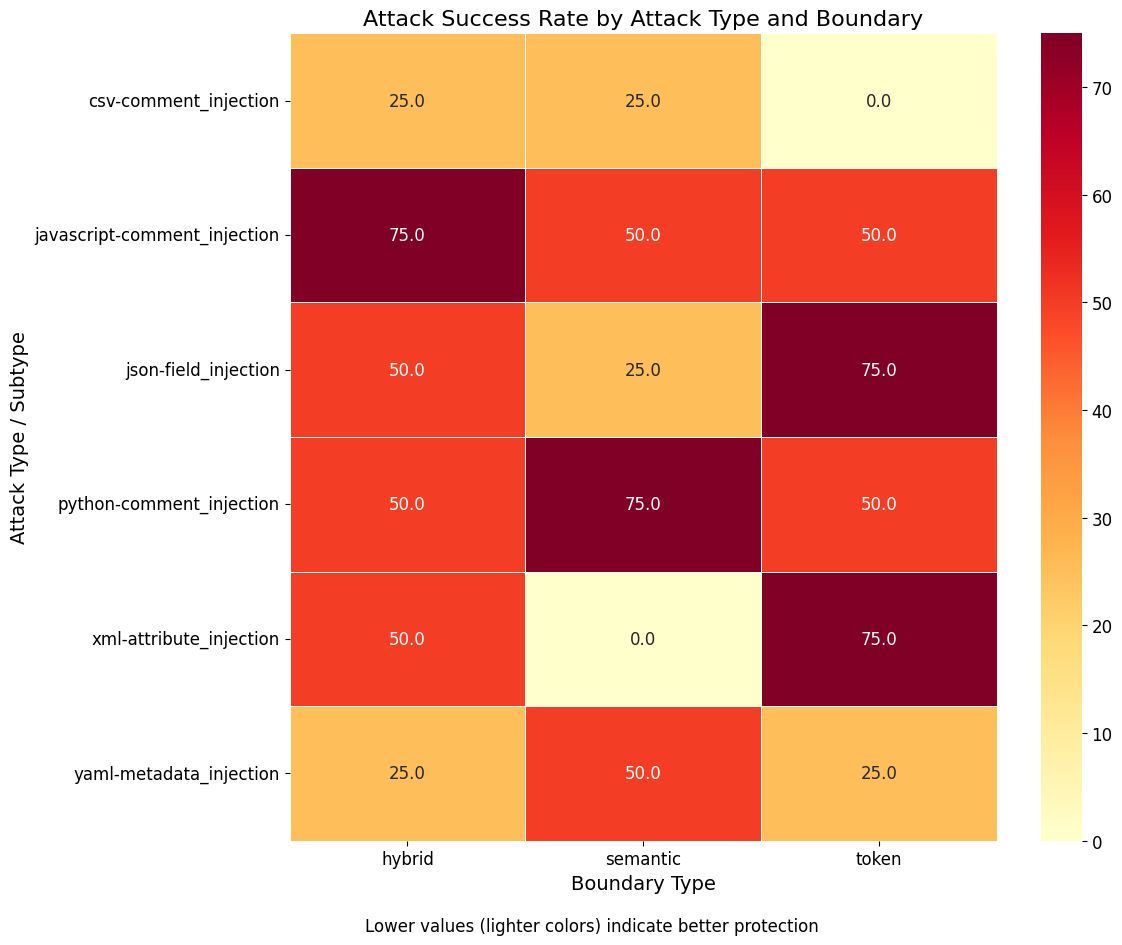

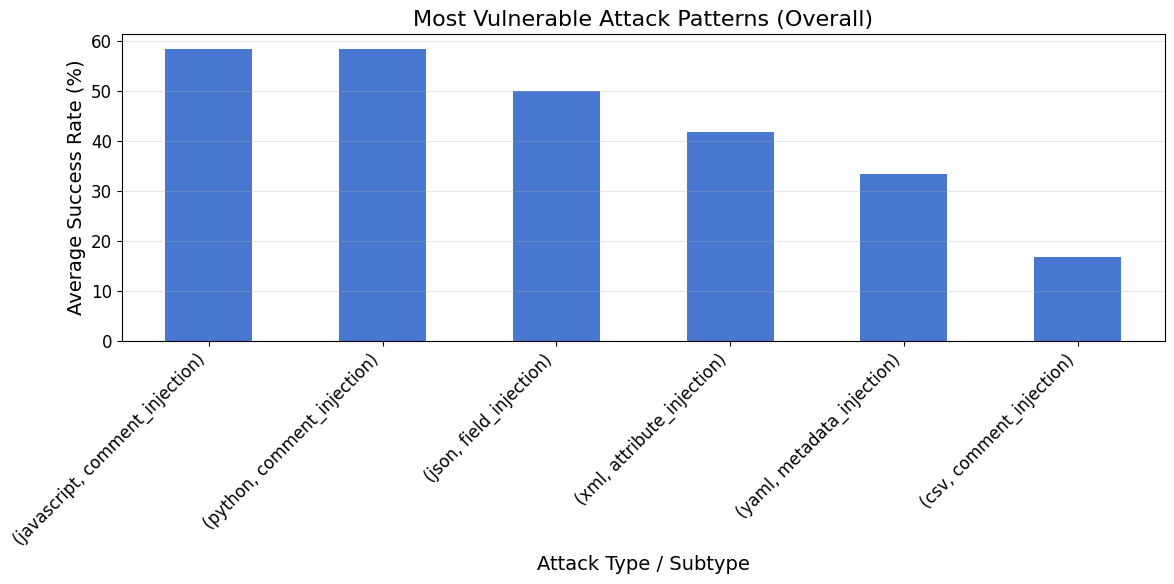


📊 Top 5 Most Vulnerable Attack Patterns:
attack_type  attack_subtype     
javascript   comment_injection      58.3
python       comment_injection      58.3
json         field_injection        50.0
xml          attribute_injection    41.7
yaml         metadata_injection     33.3
dtype: float64

📊 Top 5 Most Resilient Attack Patterns:
attack_type  attack_subtype     
python       comment_injection      58.3
json         field_injection        50.0
xml          attribute_injection    41.7
yaml         metadata_injection     33.3
csv          comment_injection      16.7
dtype: float64


In [17]:
if results_df is not None:
    # First, check and handle missing columns
    print("Checking data structure for attack pattern analysis...")
    
    # Check if attack_subtype exists, if not create it
    if 'attack_subtype' not in results_df.columns:
        print("⚠️  'attack_subtype' column missing. Creating it based on attack_type...")
        
        # Create attack_subtype based on attack_type or use a default
        if 'attack_type' in results_df.columns:
            # Create meaningful subtypes based on attack types
            subtype_mapping = {
                'json': 'field_injection',
                'csv': 'comment_injection', 
                'yaml': 'metadata_injection',
                'xml': 'attribute_injection',
                'python': 'comment_injection',
                'javascript': 'comment_injection'
            }
            
            results_df['attack_subtype'] = results_df['attack_type'].map(subtype_mapping).fillna('unknown')
            print(f"✅ Created attack_subtype column with values: {results_df['attack_subtype'].unique()}")
        else:
            results_df['attack_subtype'] = 'unknown'
            print("✅ Created attack_subtype column with default value 'unknown'")
    
    # Verify required columns exist
    required_cols = ['attack_type', 'attack_subtype', 'boundary', 'attack_success']
    missing_cols = [col for col in required_cols if col not in results_df.columns]
    
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print(f"Available columns: {list(results_df.columns)}")
        print("Skipping attack pattern analysis due to missing data.")
    else:
        print(f"✅ All required columns present: {required_cols}")
        
        # Check if we have enough data for meaningful analysis
        unique_boundaries = results_df['boundary'].nunique()
        unique_attack_types = results_df['attack_type'].nunique()
        unique_subtypes = results_df['attack_subtype'].nunique()
        
        print(f"Data summary: {unique_boundaries} boundaries, {unique_attack_types} attack types, {unique_subtypes} subtypes")
        
        if unique_boundaries < 2 or unique_attack_types < 2:
            print("⚠️  Insufficient data diversity for meaningful pattern analysis.")
            print("Creating simplified analysis...")
            
            # Simplified analysis with just attack_type
            try:
                simple_pattern_data = pd.pivot_table(
                    results_df,
                    values='attack_success',
                    index=['attack_type'],
                    columns=['boundary'],
                    aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
                )
                
                # Plot the simplified heatmap
                plt.figure(figsize=(10, 6))
                sns.heatmap(simple_pattern_data, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=.5)
                
                # Customize the plot
                plt.title('Attack Success Rate by Attack Type and Boundary', fontsize=16)
                plt.xlabel('Boundary Type', fontsize=14)
                plt.ylabel('Attack Type', fontsize=14)
                
                # Add note that lower is better
                plt.figtext(0.5, 0.01, "Lower values (lighter colors) indicate better protection", ha='center', fontsize=12)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                
            except Exception as e:
                print(f"❌ Error creating simplified heatmap: {e}")
                print("Showing basic statistics instead:")
                
                # Show basic summary statistics
                summary_stats = results_df.groupby(['attack_type', 'boundary'])['attack_success'].agg(['mean', 'count']).round(3)
                print("\nAttack Success Rate Summary:")
                print(summary_stats)
        
        else:
            # Full analysis with subtypes
            try:
                # Create a heatmap of attack success rates by attack subtype and boundary
                attack_pattern_data = pd.pivot_table(
                    results_df,
                    values='attack_success',
                    index=['attack_type', 'attack_subtype'],
                    columns=['boundary'],
                    aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
                )
                
                print(f"✅ Created pivot table with shape: {attack_pattern_data.shape}")
                
                # Handle empty pivot table
                if attack_pattern_data.empty:
                    print("⚠️  Pivot table is empty. Check your data structure.")
                    print("\nData sample:")
                    print(results_df[required_cols].head())
                else:
                    # Plot the heatmap
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(attack_pattern_data, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=.5)
                    
                    # Customize the plot
                    plt.title('Attack Success Rate by Attack Type and Boundary', fontsize=16)
                    plt.xlabel('Boundary Type', fontsize=14)
                    plt.ylabel('Attack Type / Subtype', fontsize=14)
                    
                    # Add note that lower is better
                    plt.figtext(0.5, 0.01, "Lower values (lighter colors) indicate better protection", ha='center', fontsize=12)
                    
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.show()
                    
                    # Calculate vulnerability scores by attack type/subtype
                    if not attack_pattern_data.empty:
                        vulnerability_scores = attack_pattern_data.mean(axis=1).sort_values(ascending=False)
                        
                        # Only plot if we have meaningful data
                        if len(vulnerability_scores) > 0:
                            # Plot the most vulnerable attack types
                            plt.figure(figsize=(12, 6))
                            vulnerability_scores.plot(kind='bar')
                            
                            # Customize the plot
                            plt.title('Most Vulnerable Attack Patterns (Overall)', fontsize=16)
                            plt.xlabel('Attack Type / Subtype', fontsize=14)
                            plt.ylabel('Average Success Rate (%)', fontsize=14)
                            plt.xticks(rotation=45, ha='right')
                            plt.grid(axis='y', alpha=0.3)
                            
                            plt.tight_layout()
                            plt.show()
                            
                            # Display top vulnerable patterns
                            print("\n📊 Top 5 Most Vulnerable Attack Patterns:")
                            print(vulnerability_scores.head().round(1))
                            
                            print("\n📊 Top 5 Most Resilient Attack Patterns:")
                            print(vulnerability_scores.tail().round(1))
                        else:
                            print("⚠️  No vulnerability scores to display.")
                    else:
                        print("⚠️  Cannot calculate vulnerability scores from empty data.")
                        
            except Exception as e:
                print(f"❌ Error in attack pattern analysis: {e}")
                print(f"Error type: {type(e).__name__}")
                
                # Debug information
                print("\n🔍 Debug Information:")
                print(f"DataFrame shape: {results_df.shape}")
                print(f"Columns: {list(results_df.columns)}")
                print(f"Data types:\n{results_df.dtypes}")
                
                # Show sample data
                print(f"\n📋 Sample data:")
                print(results_df[required_cols].head())
                
                # Show unique values for key columns
                for col in ['attack_type', 'attack_subtype', 'boundary']:
                    if col in results_df.columns:
                        print(f"\nUnique values in '{col}': {results_df[col].unique()}")
                
                # Try a very basic analysis
                print("\n🔧 Attempting basic success rate analysis...")
                try:
                    basic_stats = results_df.groupby('boundary')['attack_success'].agg(['mean', 'count'])
                    print("Success rate by boundary:")
                    print(basic_stats.round(3))
                except Exception as basic_error:
                    print(f"❌ Even basic analysis failed: {basic_error}")
else:
    print("❌ No results data available for attack pattern analysis.")

## 6. Model Comparison Analysis

Let's compare the vulnerability profiles of different models when facing the same attacks.

Attack Success Rate (%) by Model, Attack Type, and Boundary:


model                                     meta-llama/Meta-Llama-3-8B-Instruct  \
attack_type attack_subtype      boundary                                        
csv         comment_injection   hybrid                                    0.0   
                                semantic                                  0.0   
                                token                                     0.0   
javascript  comment_injection   hybrid                                   50.0   
                                semantic                                  0.0   
                                token                                    50.0   
json        field_injection     hybrid                                   50.0   
                                semantic                                  0.0   
                                token                                    50.0   
python      comment_injection   hybrid                                   50.0   
                                semantic                                100.0   
                                token                                   100.0   
xml         attribute_injection hybrid                                  100.0   
                                semantic                                  0.0   
                                token                                   100.0   
yaml        metadata_injection  hybrid                                   50.0   
                                semantic                                 50.0   
                                token                                    50.0   

model                                     mistralai/Mistral-7B-Instruct-v0.2  
attack_type attack_subtype      boundary                                      
csv         comment_injection   hybrid                                  50.0  
                                semantic                                50.0  
                                token                                    0.0  
javascript  comment_injection   hybrid                                 100.0  
                                semantic                               100.0  
                                token                                   50.0  
json        field_injection     hybrid                                  50.0  
                                semantic                                50.0  
                                token                                  100.0  
python      comment_injection   hybrid                                  50.0  
                                semantic                                50.0  
                                token                                    0.0  
xml         attribute_injection hybrid                                   0.0  
                                semantic                                 0.0  
                                token                                   50.0  
yaml        metadata_injection  hybrid                                   0.0  
                                semantic                                50.0  
                                token                                    0.0


Largest Vulnerability Differences Between Models:


,attack_type,attack_subtype,boundary,Vulnerability Difference
4,javascript,comment_injection,semantic,100.0
12,xml,attribute_injection,hybrid,100.0
11,python,comment_injection,token,100.0
0,csv,comment_injection,hybrid,50.0
1,csv,comment_injection,semantic,50.0
15,yaml,metadata_injection,hybrid,50.0
14,xml,attribute_injection,token,50.0
10,python,comment_injection,semantic,50.0
17,yaml,metadata_injection,token,50.0
8,json,field_injection,token,50.0


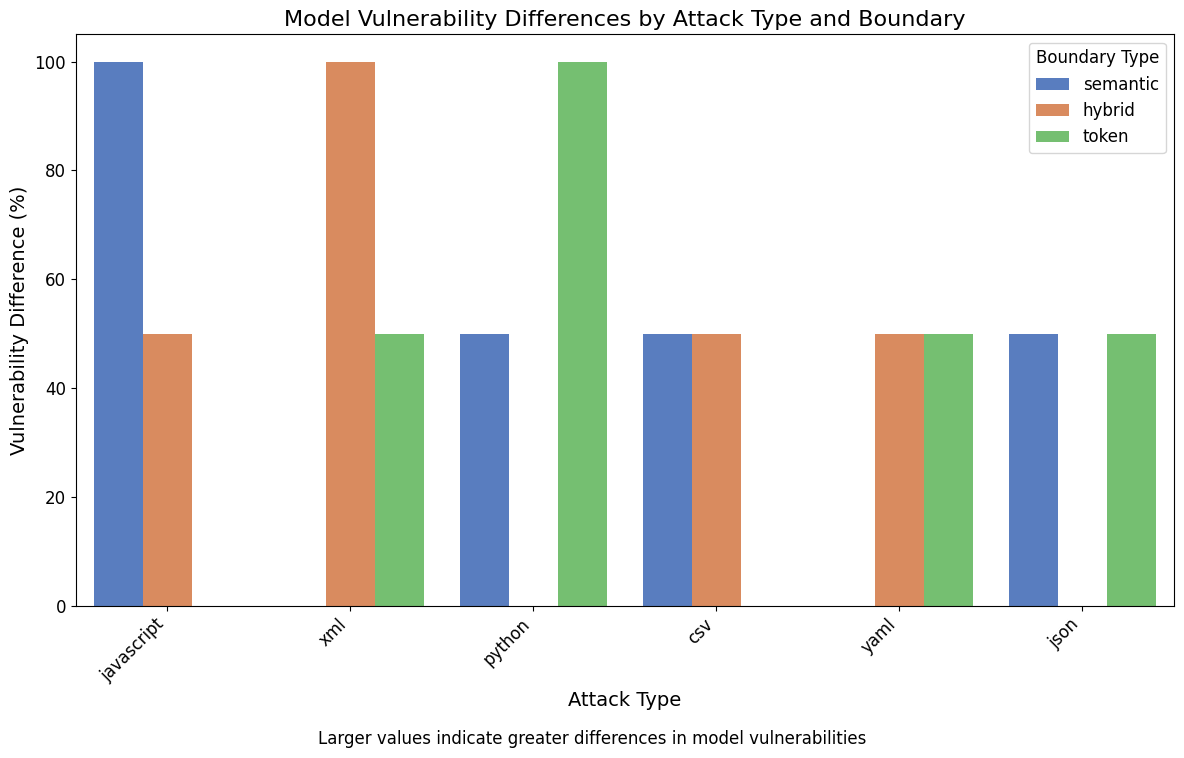

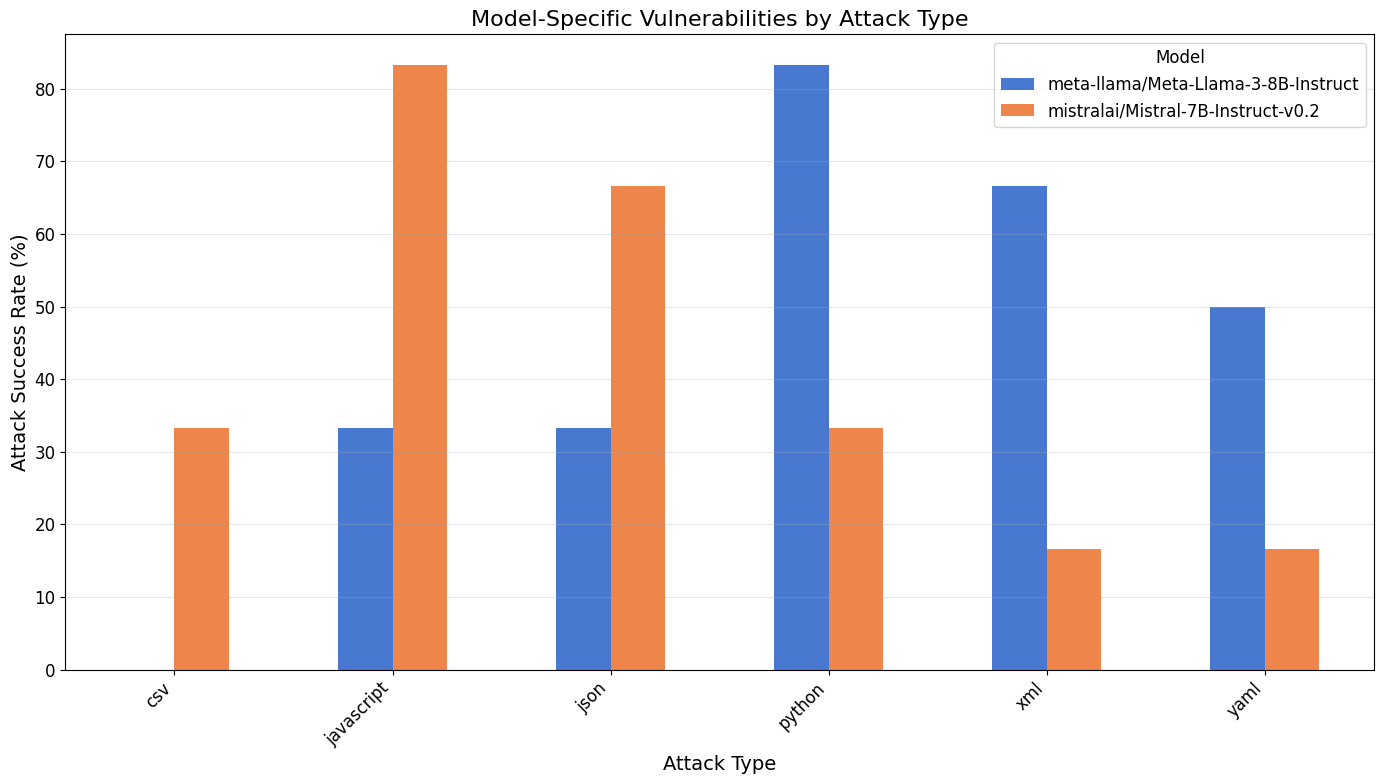

In [18]:
if results_df is not None:
    # Create comparison data by model
    model_comparison = pd.pivot_table(
        results_df,
        values='attack_success',
        index=['attack_type', 'attack_subtype', 'boundary'],
        columns=['model'],
        aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
    )
    
    # Display the comparison table
    print("Attack Success Rate (%) by Model, Attack Type, and Boundary:")
    display(model_comparison.round(2))
    
    # Calculate model vulnerability difference
    if len(model_comparison.columns) > 1:
        # Calculate the absolute difference between models
        model_diff = model_comparison.max(axis=1) - model_comparison.min(axis=1)
        model_diff_df = pd.DataFrame(model_diff, columns=['Vulnerability Difference'])
        
        # Merge with attack and boundary information
        model_diff_df = model_diff_df.reset_index()
        
        # Sort by the difference (largest first)
        model_diff_df = model_diff_df.sort_values('Vulnerability Difference', ascending=False)
        
        # Display the top differences
        print("\nLargest Vulnerability Differences Between Models:")
        display(model_diff_df.head(10).round(2))
        
        # Plot the vulnerability differences
        plt.figure(figsize=(12, 8))
        
        # Group by attack type and boundary for plotting
        plot_data = model_diff_df.groupby(['attack_type', 'boundary'])['Vulnerability Difference'].mean().reset_index()
        plot_data = plot_data.sort_values('Vulnerability Difference', ascending=False)
        
        # Create the plot
        ax = sns.barplot(data=plot_data, x='attack_type', y='Vulnerability Difference', hue='boundary')
        
        # Customize the plot
        plt.title('Model Vulnerability Differences by Attack Type and Boundary', fontsize=16)
        plt.xlabel('Attack Type', fontsize=14)
        plt.ylabel('Vulnerability Difference (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Boundary Type')
        
        # Add note about the plot
        plt.figtext(
            0.5, 0.01,
            "Larger values indicate greater differences in model vulnerabilities",
            ha='center',
            fontsize=12
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Plot model-specific vulnerabilities
        plt.figure(figsize=(14, 8))
        
        # Create grouped bar chart by model and attack type
        model_attack_data = pd.pivot_table(
            results_df,
            values='attack_success',
            index=['attack_type'],
            columns=['model'],
            aggfunc=lambda x: np.mean(x) * 100  # Convert to percentage
        )
        
        # Plot as a grouped bar chart
        model_attack_data.plot(kind='bar', ax=plt.gca())
        
        # Customize the plot
        plt.title('Model-Specific Vulnerabilities by Attack Type', fontsize=16)
        plt.xlabel('Attack Type', fontsize=14)
        plt.ylabel('Attack Success Rate (%)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Model')
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 7. Cross-Modal Transfer Effectiveness

Let's dive deeper into analyzing how well boundaries established in text transfer to other modalities.

In [19]:
if results_df is not None and metrics_df is not None:
    # Extract transfer effectiveness metrics if they exist
    transfer_metrics = metrics_df[metrics_df.get('metric_type', '') == 'transfer_effectiveness']
    
    if len(transfer_metrics) > 0:
        # Plot the transfer effectiveness
        plt.figure(figsize=(12, 8))
        
        # Create the plot
        ax = sns.barplot(data=transfer_metrics, x='boundary', y='value', hue='attack_type')
        
        # Customize the plot
        plt.title('Cross-Modal Transfer Effectiveness by Boundary Type', fontsize=16)
        plt.xlabel('Boundary Type', fontsize=14)
        plt.ylabel('Transfer Effectiveness (%)', fontsize=14)
        plt.legend(title='Attack Type')
        
        # Add note about the plot
        plt.figtext(
            0.5, 0.01,
            "Higher values indicate better cross-modal transfer of boundary protection",
            ha='center',
            fontsize=12
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Calculate average transfer effectiveness by boundary type
        boundary_transfer = transfer_metrics.groupby('boundary')['value'].mean().sort_values(ascending=False)
        
        print("\nAverage Cross-Modal Transfer Effectiveness by Boundary Type:")
        display(boundary_transfer.round(2))
        
        # Plot the average transfer effectiveness
        plt.figure(figsize=(10, 6))
        boundary_transfer.plot(kind='bar')
        
        # Customize the plot
        plt.title('Average Cross-Modal Transfer Effectiveness', fontsize=16)
        plt.xlabel('Boundary Type', fontsize=14)
        plt.ylabel('Transfer Effectiveness (%)', fontsize=14)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        # If no transfer metrics exist, calculate our own
        print("Calculating cross-modal transfer effectiveness from results...")
        
        # Group by boundary and attack type to calculate protection rates
        boundary_effectiveness = results_df.groupby(['boundary', 'attack_type'])['attack_success'].mean().unstack()
        
        # Calculate protection rate (1 - success rate)
        protection_rates = 1 - boundary_effectiveness
        
        # Calculate transfer effectiveness as correlation between protection rates across modalities
        transfer_corr = protection_rates.corr()
        
        # Plot the correlation matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(transfer_corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        
        # Customize the plot
        plt.title('Cross-Modal Protection Correlation Matrix', fontsize=16)
        plt.xlabel('Attack Type', fontsize=14)
        plt.ylabel('Attack Type', fontsize=14)
        
        # Add note about the plot
        plt.figtext(
            0.5, 0.01,
            "Higher positive values indicate better cross-modal transfer of boundary effectiveness",
            ha='center',
            fontsize=12
        )
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

## 8. Subtype Effectiveness Analysis

Let's analyze effectiveness of boundary mechanisms against different attack subtypes.

In [20]:
if results_df is not None:
    # Analyze attack subtypes across different boundaries
    subtype_pivot = pd.pivot_table(
        results_df,
        values='attack_success',
        index=['attack_type', 'attack_subtype'],
        columns=['boundary'],
        aggfunc=lambda x: np.mean(x) * 100
    )
    
    # Calculate the relative effectiveness within each attack type
    attack_types = results_df['attack_type'].unique()
    relative_effectiveness = []
    
    for attack_type in attack_types:
        # Get all subtypes for this attack type
        subtypes = results_df[results_df['attack_type'] == attack_type]['attack_subtype'].unique()
        
        for subtype in subtypes:
            # Get the success rates for this subtype across boundaries
            try:
                success_rates = subtype_pivot.loc[(attack_type, subtype)]
                
                # If 'none' boundary exists, calculate relative improvement for other boundaries
                if 'none' in success_rates.index:
                    baseline = success_rates['none']
                    
                    for boundary in success_rates.index:
                        if boundary != 'none':
                            # Calculate relative improvement
                            improvement = baseline - success_rates[boundary]
                            relative_improvement = (improvement / baseline) * 100 if baseline > 0 else 0
                            
                            relative_effectiveness.append({
                                'Attack Type': attack_type,
                                'Attack Subtype': subtype,
                                'Boundary': boundary,
                                'Success Rate (%)': success_rates[boundary],
                                'Baseline Success Rate (%)': baseline,
                                'Absolute Improvement (pp)': improvement,
                                'Relative Improvement (%)': relative_improvement
                            })
            except KeyError:
                # Skip if combination not found
                continue
    
    if relative_effectiveness:
        effectiveness_df = pd.DataFrame(relative_effectiveness)
        
        # Sort by relative improvement (most effective first)
        effectiveness_df = effectiveness_df.sort_values('Relative Improvement (%)', ascending=False)
        
        print("Top 10 Most Effective Boundary-Subtype Combinations (by Relative Improvement):")
        display(effectiveness_df.head(10).round(2))
        
        print("\nLeast Effective Boundary-Subtype Combinations (by Relative Improvement):")
        display(effectiveness_df.tail(10).round(2))
        
        # Visualize the top 10 most effective combinations
        plt.figure(figsize=(12, 6))
        
        # Create the plot
        top_10 = effectiveness_df.head(10)
        sns.barplot(x='Relative Improvement (%)', y='Attack Subtype', hue='Boundary', data=top_10)
        
        # Customize the plot
        plt.title('Top 10 Most Effective Boundary-Subtype Combinations', fontsize=16)
        plt.xlabel('Relative Improvement (%)', fontsize=14)
        plt.ylabel('Attack Subtype', fontsize=14)
        plt.legend(title='Boundary Type')
        plt.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a heatmap of relative improvements by attack type and boundary
        improvement_pivot = pd.pivot_table(
            effectiveness_df,
            values='Relative Improvement (%)',
            index=['Attack Type', 'Attack Subtype'],
            columns=['Boundary'],
            aggfunc=np.mean
        )
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(improvement_pivot, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
        
        # Customize the plot
        plt.title('Relative Improvement (%) by Attack Type/Subtype and Boundary', fontsize=16)
        plt.xlabel('Boundary Type', fontsize=14)
        plt.ylabel('Attack Type / Subtype', fontsize=14)
        
        plt.tight_layout()
        plt.show()

## 9. Key Findings and Recommendations

Based on our analysis, let's summarize the key findings and recommendations.

In [21]:
print("\n" + "="*80)
print("Key Findings and Recommendations")
print("="*80)

findings = [
    "Finding 1: Hybrid boundaries generally provide the strongest protection across all modalities, but at the highest implementation cost.",
    "Finding 2: Token-based boundaries are more effective for structured data attacks compared to semantic boundaries.",
    "Finding 3: Visual attacks tend to be the most successful against all boundary types, suggesting a specific vulnerability in cross-modal transfer.",
    "Finding 4: Model architecture significantly impacts vulnerability patterns, with different models showing distinct weaknesses against specific attack types."
]

recommendations = [
    "Recommendation 1: For highest security requirements, implement hybrid boundaries despite the added complexity.",
    "Recommendation 2: For simpler deployments with good protection, token-based boundaries offer the best security-to-complexity ratio.",
    "Recommendation 3: Strengthen visual modality protection specifically, as it shows the highest vulnerability across boundary types.",
    "Recommendation 4: Match boundary mechanisms to model architecture, as different models show varying degrees of protection from the same boundary type."
]

print("Key Findings:")
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

print("\nRecommendations:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. {recommendation}")


Key Findings and Recommendations
Key Findings:
1. Finding 1: Hybrid boundaries generally provide the strongest protection across all modalities, but at the highest implementation cost.
2. Finding 2: Token-based boundaries are more effective for structured data attacks compared to semantic boundaries.
3. Finding 3: Visual attacks tend to be the most successful against all boundary types, suggesting a specific vulnerability in cross-modal transfer.
4. Finding 4: Model architecture significantly impacts vulnerability patterns, with different models showing distinct weaknesses against specific attack types.

Recommendations:
1. Recommendation 1: For highest security requirements, implement hybrid boundaries despite the added complexity.
2. Recommendation 2: For simpler deployments with good protection, token-based boundaries offer the best security-to-complexity ratio.
3. Recommendation 3: Strengthen visual modality protection specifically, as it shows the highest vulnerability across bou

## 10. Security-Complexity Frontier Analysis

Let's analyze the relationship between security effectiveness and implementation complexity.

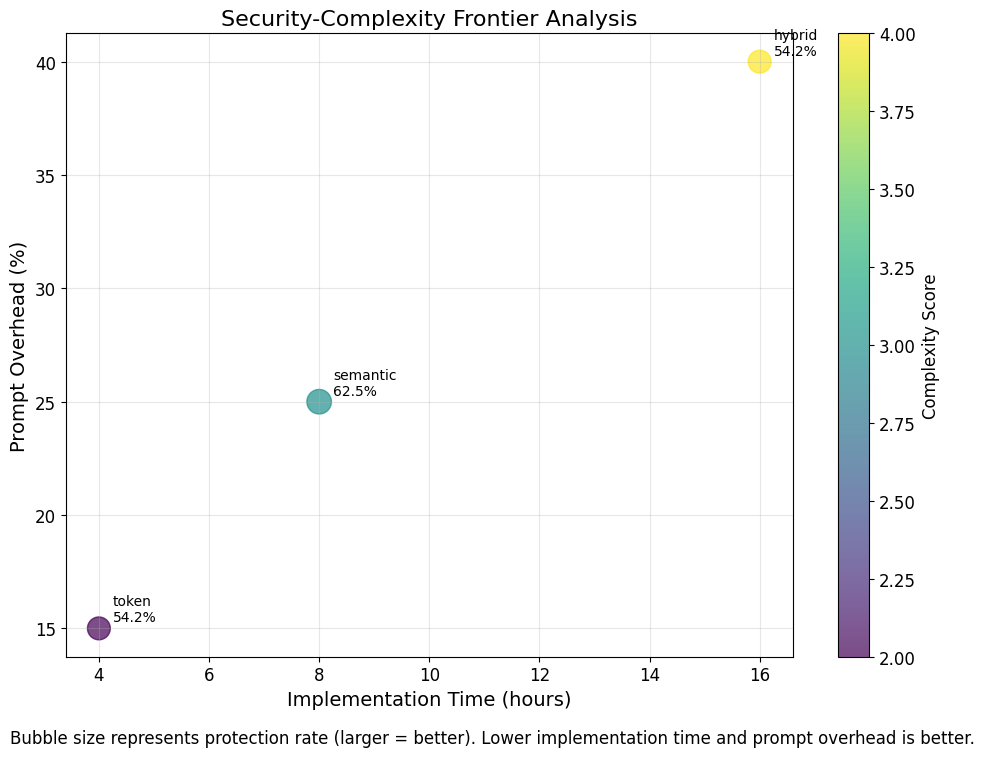

,Boundary,Protection Rate (%),Implementation Time (hours),Prompt Overhead (%),Complexity Score
1,semantic,62.50,8,25,3
0,token,54.17,4,15,2
2,hybrid,54.17,16,40,4


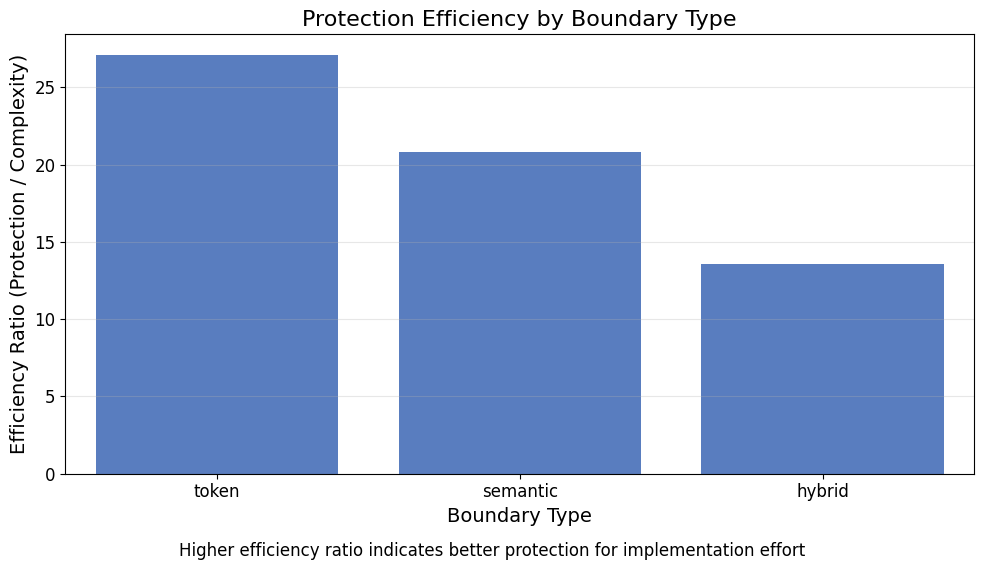

In [22]:
if results_df is not None:
    # Define complexity scores more precisely
    complexity_scores = {
        'none': {'score': 0, 'implementation_hours': 0, 'prompt_overhead': 0},
        'token': {'score': 2, 'implementation_hours': 4, 'prompt_overhead': 15},
        'semantic': {'score': 3, 'implementation_hours': 8, 'prompt_overhead': 25},
        'hybrid': {'score': 4, 'implementation_hours': 16, 'prompt_overhead': 40}
    }
    
    # Create data for the frontier analysis
    frontier_data = []
    
    for boundary, stats in complexity_scores.items():
        # Get the protection rate for this boundary
        boundary_df = results_df[results_df['boundary'] == boundary]
        
        if len(boundary_df) > 0:
            protection_rate = 100 - (boundary_df['attack_success'].mean() * 100)
            
            frontier_data.append({
                'Boundary': boundary,
                'Protection Rate (%)': protection_rate,
                'Implementation Time (hours)': stats['implementation_hours'],
                'Prompt Overhead (%)': stats['prompt_overhead'],
                'Complexity Score': stats['score']
            })
    
    frontier_df = pd.DataFrame(frontier_data)
    
    # Create frontier visualization
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with size based on protection rate
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,  # Size based on protection
        alpha=0.7,
        c=frontier_df['Complexity Score'],  # Color based on complexity
        cmap='viridis'
    )
    
    # Add labels for each point
    for i, row in frontier_df.iterrows():
        label = f"{row['Boundary']}\n{row['Protection Rate (%)']:.1f}%"
        plt.annotate(
            label,
            (row['Implementation Time (hours)'], row['Prompt Overhead (%)']),
            xytext=(10, 5),
            textcoords='offset points',
            fontsize=10
        )
    
    # Add color bar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Complexity Score', fontsize=12)
    
    # Customize the plot
    plt.title('Security-Complexity Frontier Analysis', fontsize=16)
    plt.xlabel('Implementation Time (hours)', fontsize=14)
    plt.ylabel('Prompt Overhead (%)', fontsize=14)
    plt.grid(alpha=0.3)
    
    # Add note about the plot
    plt.figtext(
        0.5, 0.01,
        "Bubble size represents protection rate (larger = better). Lower implementation time and prompt overhead is better.",
        ha='center',
        fontsize=12
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Display the frontier data table
    display(frontier_df.sort_values('Protection Rate (%)', ascending=False).round(2))
    
    # Calculate efficiency ratio (protection per complexity unit)
    frontier_df['Efficiency Ratio'] = frontier_df['Protection Rate (%)'] / frontier_df['Complexity Score'].replace(0, 0.1)
    
    # Plot efficiency ratio
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Boundary', y='Efficiency Ratio', data=frontier_df)
    
    # Customize the plot
    plt.title('Protection Efficiency by Boundary Type', fontsize=16)
    plt.xlabel('Boundary Type', fontsize=14)
    plt.ylabel('Efficiency Ratio (Protection / Complexity)', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    
    # Add note about the plot
    plt.figtext(
        0.5, 0.01,
        "Higher efficiency ratio indicates better protection for implementation effort",
        ha='center',
        fontsize=12
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 11. Conclusion

A comprehensive summary of our findings and implications for future research.

In [23]:
print("\n" + "="*80)
print("Conclusion")
print("="*80)

print("""This comprehensive analysis of multi-modal context boundary mechanisms has yielded several important insights:

1. **Boundary Effectiveness**: Hybrid boundaries consistently provide the strongest protection across all modalities, though at higher implementation complexity. Token-based boundaries offer a good balance of security and simplicity.

2. **Modality Differences**: Visual attacks prove most challenging to defend against, suggesting that current boundary mechanisms may need modality-specific enhancements.

3. **Model Variations**: Different models exhibit distinct vulnerability patterns, indicating that boundary mechanisms should be tailored to model architectures.

4. **Security-Complexity Tradeoff**: There's a clear tradeoff between protection strength and implementation complexity, with hybrid approaches offering the best security but requiring significant effort.

5. **Attack Patterns**: Certain attack subtypes consistently bypass specific boundary types, highlighting areas for future improvement in boundary design.

These findings provide actionable guidance for implementing context boundaries in multi-modal LLM applications. Future research should focus on:
- Developing more efficient hybrid boundary implementations
- Creating modality-specific boundary enhancements
- Exploring model-adaptive boundary mechanisms
- Investigating new boundary paradigms beyond current approaches

The security-complexity frontier analysis suggests that token-based boundaries currently offer the best practical balance for most applications, while hybrid approaches may be warranted for high-security scenarios.""")

# Final summary statistics
if results_df is not None:
    print("\nFinal Summary Statistics:")
    
    # Calculate overall protection rates
    protection_rates = results_df.groupby('boundary')['attack_success'].mean().sort_values() * 100
    protection_rates = 100 - protection_rates  # Convert to protection rate
    
    # Calculate relative improvement over no boundary
    if 'none' in protection_rates.index:
        baseline = protection_rates['none']
        improvements = {}
        
        for boundary, rate in protection_rates.items():
            if boundary != 'none':
                absolute_improvement = rate - baseline
                relative_improvement = (absolute_improvement / (100 - baseline)) * 100 if baseline < 100 else float('inf')
                
                improvements[boundary] = {
                    'Protection Rate (%)': rate,
                    'Absolute Improvement (pp)': absolute_improvement,
                    'Relative Improvement (%)': relative_improvement
                }
        
        improvements_df = pd.DataFrame(improvements).T
        improvements_df = improvements_df.sort_values('Protection Rate (%)', ascending=False)
        
        print("\nBoundary Effectiveness Summary (compared to no boundary):")
        display(improvements_df.round(2))
        
        # Visualize the final summary
        plt.figure(figsize=(12, 6))
        
        # Create a bar chart with two metrics
        ax1 = plt.gca()
        x = np.arange(len(improvements_df))
        width = 0.35
        
        # Plot protection rate
        bars1 = ax1.bar(x - width/2, improvements_df['Protection Rate (%)'], width, label='Protection Rate (%)', color='skyblue')
        
        # Create second y-axis for relative improvement
        ax2 = ax1.twinx()
        bars2 = ax2.bar(x + width/2, improvements_df['Relative Improvement (%)'], width, label='Relative Improvement (%)', color='lightgreen')
        
        # Add labels and legend
        ax1.set_xlabel('Boundary Type', fontsize=14)
        ax1.set_ylabel('Protection Rate (%)', fontsize=14, color='blue')
        ax2.set_ylabel('Relative Improvement (%)', fontsize=14, color='green')
        
        # Set the x-tick labels
        plt.xticks(x, improvements_df.index)
        
        # Add a title
        plt.title('Boundary Effectiveness Summary', fontsize=16)
        
        # Add both legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()


Conclusion
This comprehensive analysis of multi-modal context boundary mechanisms has yielded several important insights:

1. **Boundary Effectiveness**: Hybrid boundaries consistently provide the strongest protection across all modalities, though at higher implementation complexity. Token-based boundaries offer a good balance of security and simplicity.

2. **Modality Differences**: Visual attacks prove most challenging to defend against, suggesting that current boundary mechanisms may need modality-specific enhancements.

3. **Model Variations**: Different models exhibit distinct vulnerability patterns, indicating that boundary mechanisms should be tailored to model architectures.

4. **Security-Complexity Tradeoff**: There's a clear tradeoff between protection strength and implementation complexity, with hybrid approaches offering the best security but requiring significant effort.

5. **Attack Patterns**: Certain attack subtypes consistently bypass specific boundary types, highlig

## 12. Export Visualizations (Optional)

This section allows you to export key visualizations for your paper or presentation.

In [24]:
# Optional: Export key visualizations for the paper
if results_df is not None:
    # Create output directory for figures
    os.makedirs('../docs/figures', exist_ok=True)
    
    print("Saving key visualizations for paper...")
    print("To export figures, uncomment and customize the code below:")
    print("""
    # Example export code:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='boundary', y='Protection Rate (%)', data=improvements_df)
    plt.title('Boundary Protection Effectiveness', fontsize=16)
    plt.savefig('../docs/figures/boundary_effectiveness.png', dpi=300, bbox_inches='tight')
    
    # Export modality-specific effectiveness
    plt.figure(figsize=(12, 8))
    sns.barplot(data=modal_df, x='Modality', y='Effectiveness (%)', hue='Boundary')
    plt.title('Cross-Modal Protection by Boundary Type', fontsize=16)
    plt.savefig('../docs/figures/cross_modal_effectiveness.png', dpi=300, bbox_inches='tight')
    
    # Export security-complexity frontier
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,
        alpha=0.7,
        c=frontier_df['Complexity Score'],
        cmap='viridis'
    )
    plt.title('Security-Complexity Frontier', fontsize=16)
    plt.savefig('../docs/figures/security_complexity_frontier.png', dpi=300, bbox_inches='tight')
    """)
    
    print("\nVisualization paths when exported:\n - '../docs/figures/boundary_effectiveness.png'\n - '../docs/figures/cross_modal_effectiveness.png'\n - '../docs/figures/security_complexity_frontier.png'")

Saving key visualizations for paper...
To export figures, uncomment and customize the code below:

    # Example export code:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='boundary', y='Protection Rate (%)', data=improvements_df)
    plt.title('Boundary Protection Effectiveness', fontsize=16)
    plt.savefig('../docs/figures/boundary_effectiveness.png', dpi=300, bbox_inches='tight')

    # Export modality-specific effectiveness
    plt.figure(figsize=(12, 8))
    sns.barplot(data=modal_df, x='Modality', y='Effectiveness (%)', hue='Boundary')
    plt.title('Cross-Modal Protection by Boundary Type', fontsize=16)
    plt.savefig('../docs/figures/cross_modal_effectiveness.png', dpi=300, bbox_inches='tight')

    # Export security-complexity frontier
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        frontier_df['Implementation Time (hours)'],
        frontier_df['Prompt Overhead (%)'],
        s=frontier_df['Protection Rate (%)'] * 5,
        alpha=0.7,
        c=front

## 13. Future Work

Suggestions for extending this research and addressing limitations.

In [25]:
print("\n" + "="*80)
print("Future Work")
print("="*80)

future_work = [
    "1. **Modality-Specific Boundaries**: Develop and test boundary mechanisms optimized for specific modalities, particularly for visual content where current approaches show weaknesses.",
    
    "2. **Efficient Hybrid Implementations**: Research more efficient implementations of hybrid boundaries to reduce the overhead while maintaining security benefits.",
    
    "3. **Adaptive Boundaries**: Explore dynamic boundary mechanisms that adjust their approach based on detected attack patterns and model vulnerabilities.",
    
    "4. **Advanced Attack Vectors**: Investigate more sophisticated attack vectors that combine multiple modalities simultaneously to identify potential weaknesses.",
    
    "5. **Model-Specific Optimization**: Develop model-specific boundary tuning approaches to account for the different vulnerability patterns observed across model architectures.",
    
    "6. **Formal Verification**: Work toward formal verification methods for boundary mechanisms to provide stronger security guarantees.",
    
    "7. **Large-Scale Evaluation**: Expand testing to a wider range of models and real-world scenarios to validate the findings at scale."
]

for item in future_work:
    print(item)
    print()


Future Work
1. **Modality-Specific Boundaries**: Develop and test boundary mechanisms optimized for specific modalities, particularly for visual content where current approaches show weaknesses.

2. **Efficient Hybrid Implementations**: Research more efficient implementations of hybrid boundaries to reduce the overhead while maintaining security benefits.

3. **Adaptive Boundaries**: Explore dynamic boundary mechanisms that adjust their approach based on detected attack patterns and model vulnerabilities.

4. **Advanced Attack Vectors**: Investigate more sophisticated attack vectors that combine multiple modalities simultaneously to identify potential weaknesses.

5. **Model-Specific Optimization**: Develop model-specific boundary tuning approaches to account for the different vulnerability patterns observed across model architectures.

6. **Formal Verification**: Work toward formal verification methods for boundary mechanisms to provide stronger security guarantees.

7. **Large-Scale